# Imports

In [1]:
from extractors import GerchbergSaxton2d, SpotlightSolution1d, FlattenOptimalTransport2d, ContinuousOptimalTransport2d
from utils.coordinates import CenteredGridCoordinates, RadialCoordinates
from utils.make_data import make_gauss, make_gauss_cartesian, make_donut, make_disk, get_fly_test_image
from utils.fourier import fourier_propagation, FFT2

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image 

In [2]:
def plot_side_by_side(img1, img2, title1=None, title2=None):
    fig, ax = plt.subplots(1, 4, figsize=(13, 6), gridspec_kw={'width_ratios': [6, 0.5, 6, 0.5]})
    im1 = ax[0].imshow(img1)
    im2 = ax[2].imshow(img2)
    ax[0].axis('off')
    ax[2].axis('off')
    if title1 is not None:
        ax[0].set_title(title1)
    if title2 is not None:
        ax[2].set_title(title2)
    plt.colorbar(im1, ax[1])
    plt.colorbar(im2, ax[3])
    plt.show()

In [3]:
def L2_loss(a, b):
    a = a / a.sum()
    b = b / b.sum()
    return ((a - b)**2).sum()

# Generate input / output example

In [4]:
n = 128  

# bin positions
coordGrid = CenteredGridCoordinates(n, n)
xs, ys = coordGrid.get_mesh()
r = np.sqrt(xs**2 + ys**2)

Following cell shows how to create input and output distributions that will be identical for a given coordinate grid convention. Solution to this phase retreival problem should be zero phase, but Optimal Transport will output a quadratic phase, which roughly speaking blurs out solution.

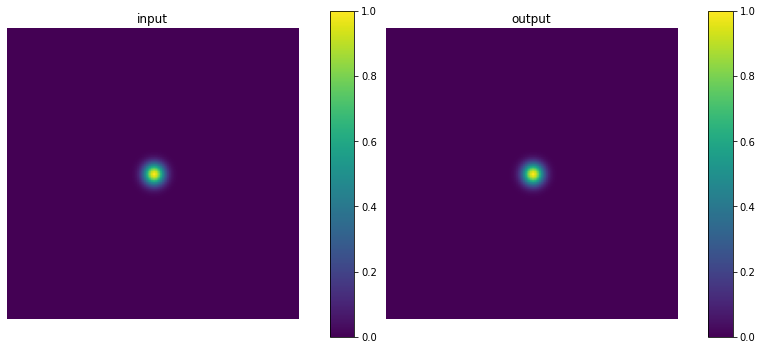

In [5]:
# create test data
a = make_gauss(r, 1/np.sqrt(2*np.pi))
b = make_gauss(r, 1/np.sqrt(2*np.pi))

assert np.isclose(
    np.abs(FFT2(np.sqrt(a)))**2/n**2, 
    make_gauss(r, 1/np.sqrt(2*np.pi))
    ).all()


plot_side_by_side(a, b, title1='input', title2='output')

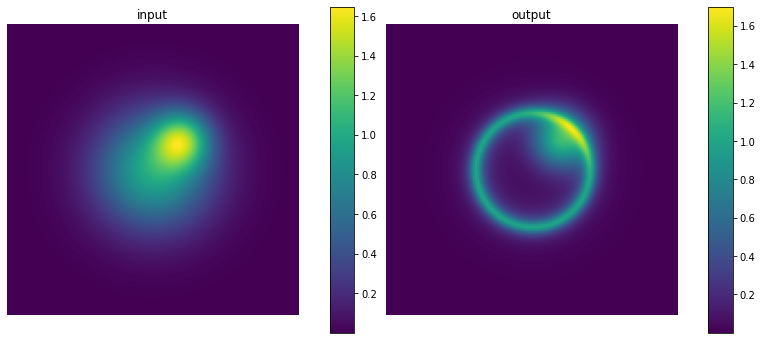

In [6]:
# create test data
a = make_gauss(r, n//5 * coordGrid.dx)
a += make_gauss_cartesian(xs, ys, n//10 * coordGrid.dx, -n//10 * coordGrid.dx,  n//10 * coordGrid.dx)

b = make_donut(r, n//5 * coordGrid.dx, n//10 * coordGrid.dx)
b += make_gauss_cartesian(xs, ys, n//10 * coordGrid.dx, -n//10 * coordGrid.dx,  n//10 * coordGrid.dx)


plot_side_by_side(a, b, title1='input', title2='output')

# Continuous Optimal Transport 

Potential(
  (linear_list): ModuleList(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): Linear(in_features=512, out_features=1024, bias=True)
  )
  (last_linear): Linear(in_features=1024, out_features=1, bias=True)
  (relu): ReLU()
)


  0%|          | 0/400 [00:00<?, ?it/s]

  1%|▏         | 5/400 [00:00<00:08, 48.41it/s]

Iter:   0, loss=0.0270798709243536


 15%|█▌        | 60/400 [00:01<00:05, 58.34it/s]

Iter:  50, loss=-0.3797442615032196


 27%|██▋       | 108/400 [00:01<00:04, 63.14it/s]

Iter: 100, loss=-0.4376485049724579


 39%|███▉      | 157/400 [00:02<00:03, 64.51it/s]

Iter: 150, loss=-0.47163596749305725


 53%|█████▎    | 213/400 [00:03<00:02, 64.70it/s]

Iter: 200, loss=-0.4964126944541931


 66%|██████▌   | 262/400 [00:04<00:02, 64.88it/s]

Iter: 250, loss=-0.5663272142410278


 78%|███████▊  | 311/400 [00:04<00:01, 64.95it/s]

Iter: 300, loss=-0.5007143616676331


 90%|█████████ | 360/400 [00:05<00:00, 63.59it/s]

Iter: 350, loss=-0.5684587359428406


100%|██████████| 16/16 [00:01<00:00, 12.56it/s]


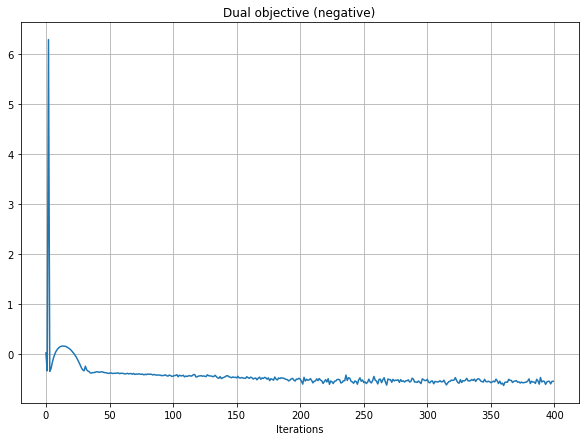

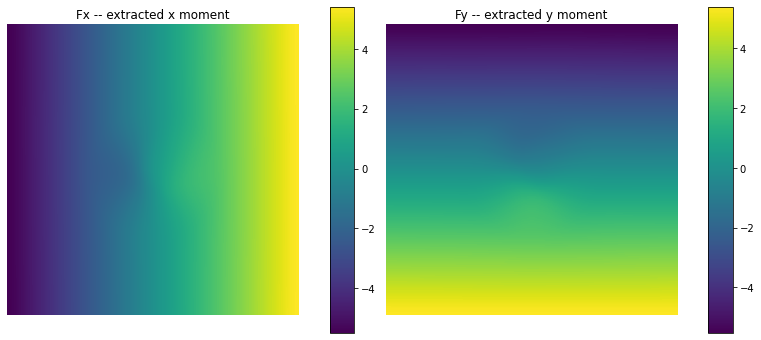

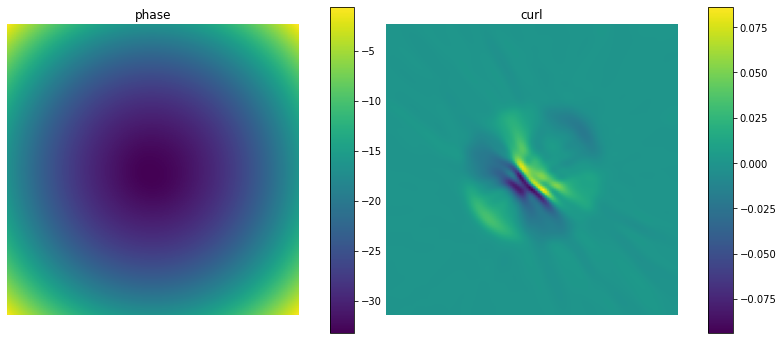

In [7]:
cot_model = ContinuousOptimalTransport2d(model_parameters={'hidden_size_0':128, 'num_layers':5}, n_iter=400, reg=0.1) # default
cot_Fx, cot_Fy, cot_phase, curl = cot_model(a, b, xs, ys)
plot_side_by_side(cot_Fx, cot_Fy, title1='Fx -- extracted x moment', title2='Fy -- extracted y moment')
plot_side_by_side(cot_phase, curl, title1='phase', title2='curl')

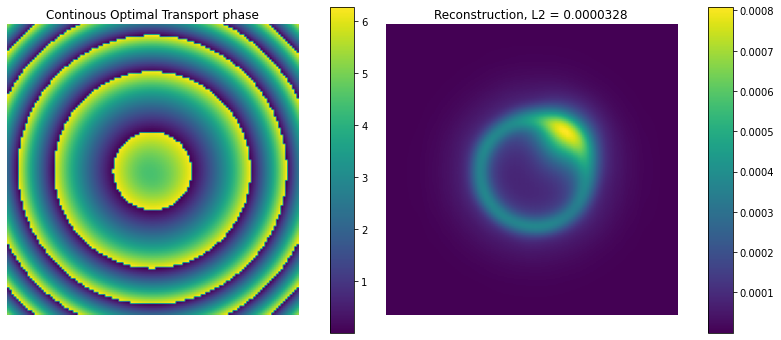

In [8]:
pred_intensity = fourier_propagation(a, cot_phase * 2 * np.pi)
l2_error = L2_loss(pred_intensity, b/b.sum())
plot_side_by_side(cot_phase % (2 * np.pi), pred_intensity, title1=f"Continous Optimal Transport phase", title2=f"Reconstruction, L2 = {l2_error:.7f}")

# Sinkhorn regularized Optimal Transport

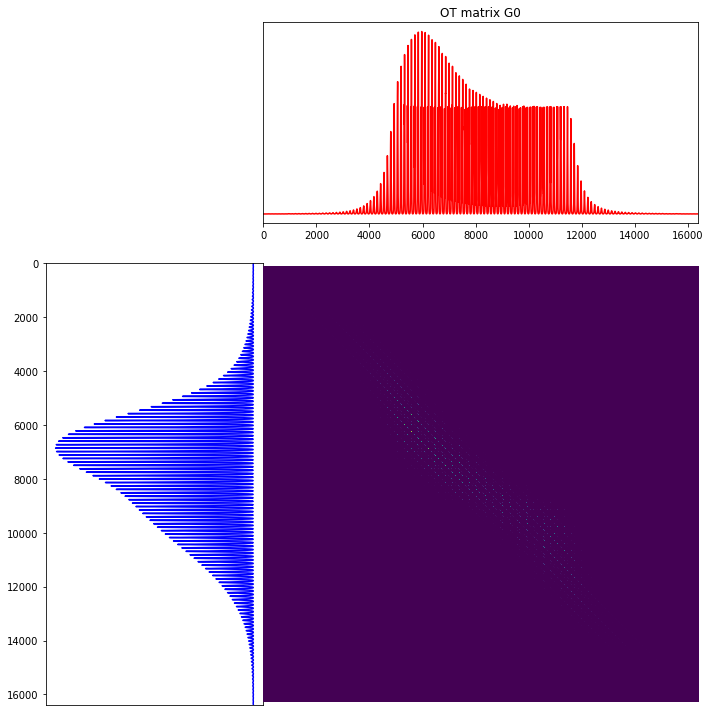

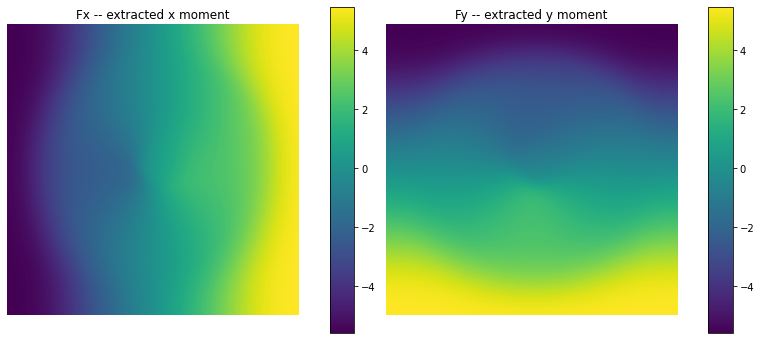

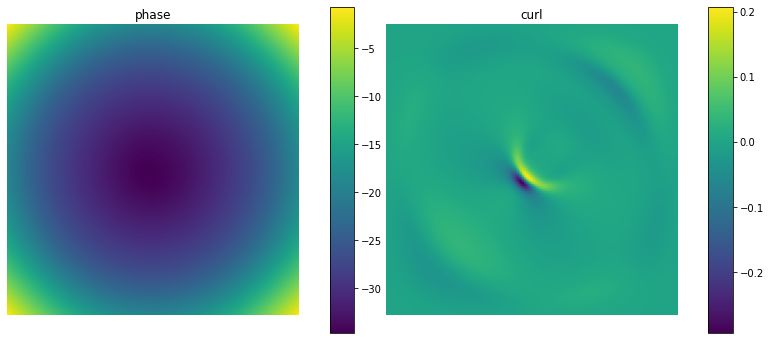

In [9]:
ot_model = FlattenOptimalTransport2d(method='sinkhorn', reg=0.001, plot_plan=True) # method is either 'emd' or 'sinkhorn'
ot_Fx, ot_Fy, ot_phase, curl = ot_model(a, b, xs, ys)
plot_side_by_side(ot_Fx, ot_Fy, title1='Fx -- extracted x moment', title2='Fy -- extracted y moment')
plot_side_by_side(ot_phase, curl, title1='phase', title2='curl')

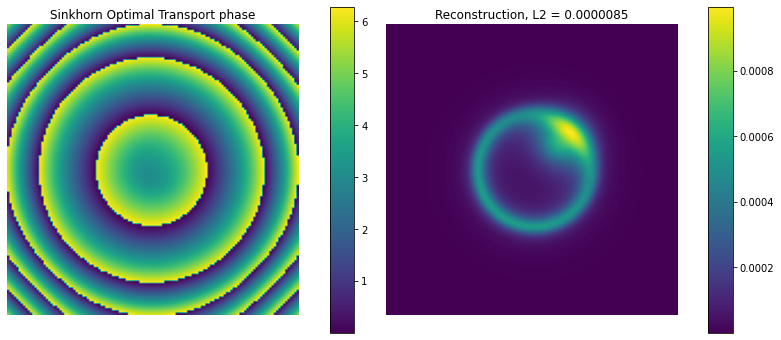

In [10]:
pred_intensity = fourier_propagation(a, ot_phase * 2 * np.pi)
l2_error = L2_loss(pred_intensity, b/b.sum())
plot_side_by_side(ot_phase % (2 * np.pi), pred_intensity, title1=f"Sinkhorn Optimal Transport phase", title2=f"Reconstruction, L2 = {l2_error:.7f}")

# For radially symmetric problems we can check spotlight solutuion

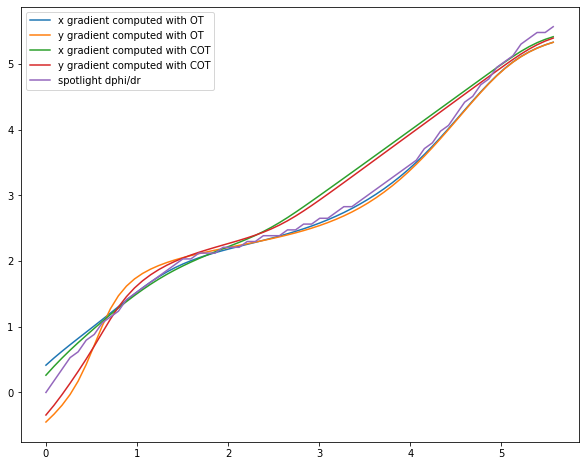

In [11]:
# extract 1d problem
r_line =r[n//2,n//2:] 
a_r = a[n//2,n//2:]*r_line
b_r = b[n//2,n//2:]*r_line
spotlight = SpotlightSolution1d()
dphidr = spotlight(a_r, b_r, r_line)

# plot and compare reuslts
plt.figure(figsize=(10, 8))
plt.plot(r_line, ot_Fx[n//2,n//2:], label='x gradient computed with OT')
plt.plot(r_line, ot_Fy[n//2:,n//2], label='y gradient computed with OT')
plt.plot(r_line, cot_Fx[n//2,n//2:], label='x gradient computed with COT')
plt.plot(r_line, cot_Fy[n//2:,n//2], label='y gradient computed with COT')
plt.plot(r_line, dphidr, label='spotlight dphi/dr')
plt.legend()
plt.show()

# Gerchberg Saxton

100%|██████████| 10000/10000 [00:17<00:00, 585.08it/s]


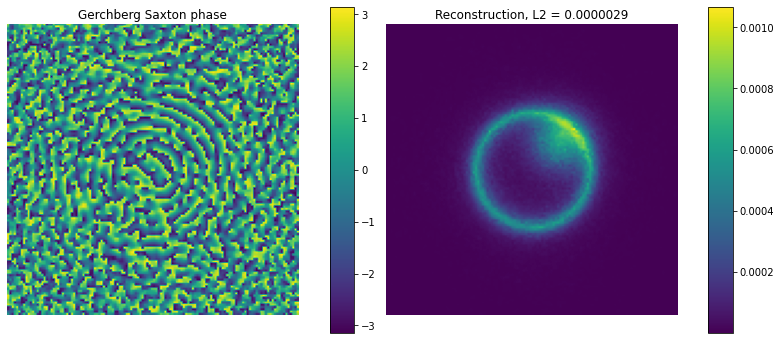

In [12]:
num_iter = 10000
gs_model = GerchbergSaxton2d(num_iter)
gs_phase = gs_model(a, b)

pred_intensity = fourier_propagation(a, gs_phase)
l2_error = L2_loss(pred_intensity, b/b.sum())
plot_side_by_side(gs_phase, pred_intensity, title1=f"Gerchberg Saxton phase", title2=f"Reconstruction, L2 = {l2_error:.7f}")

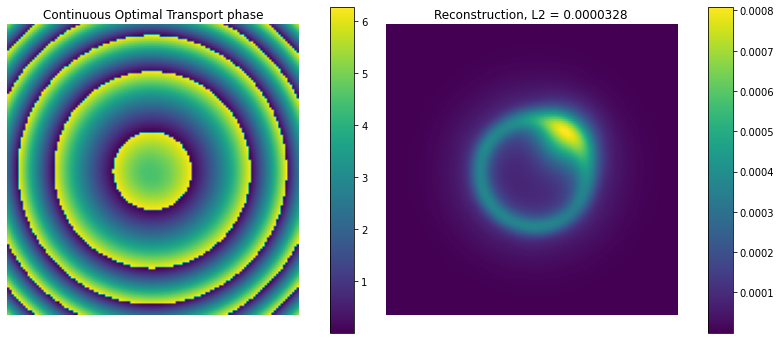

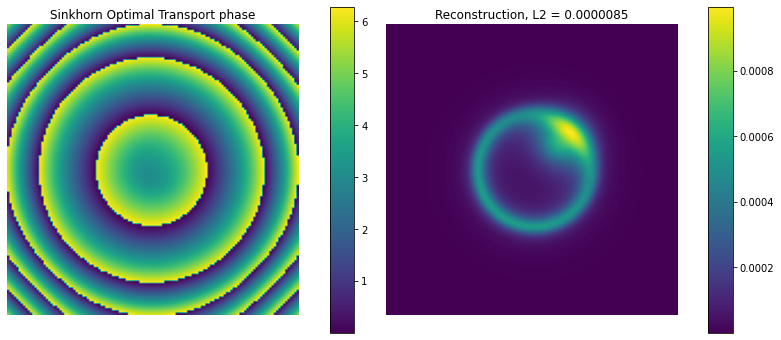

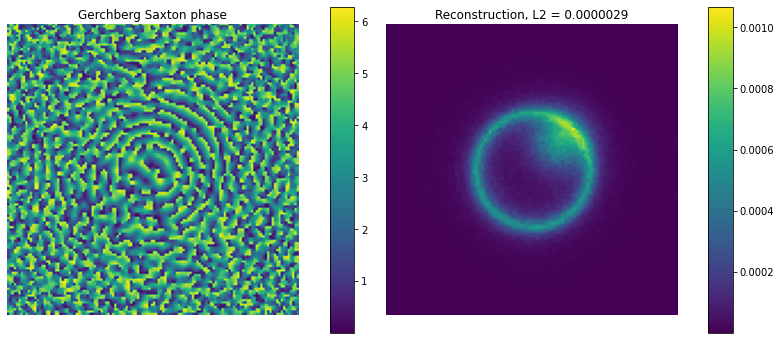

In [13]:
phases = [cot_phase, ot_phase, gs_phase]
names = ["Continuous Optimal Transport", "Sinkhorn Optimal Transport", "Gerchberg Saxton"]
for phase, name in zip(phases, names):
    if name != "Gerchberg Saxton":
        pred_intensity = fourier_propagation(a, phase * 2 * np.pi)
    else:
        pred_intensity = fourier_propagation(a, phase)
    l2_error = L2_loss(pred_intensity, b/b.sum())
    plot_side_by_side(phase % (2* np.pi), pred_intensity, title1=f"{name} phase", title2=f"Reconstruction, L2 = {l2_error:.7f}")

# Finetuning on GS

100%|██████████| 100/100 [00:00<00:00, 560.87it/s]


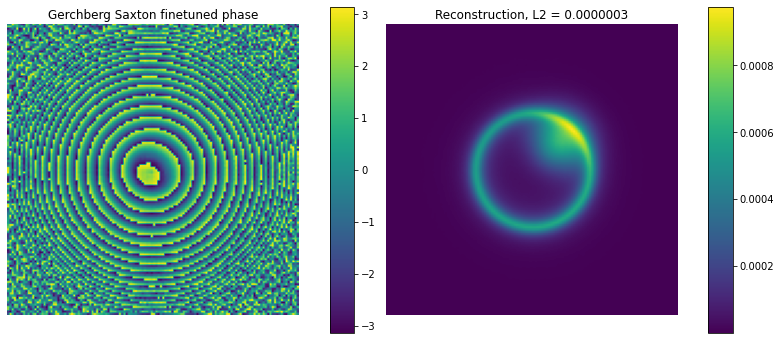

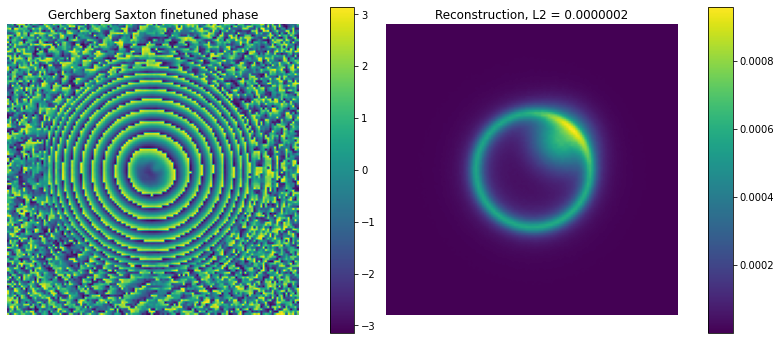

In [14]:
num_iter = 100
gs_model = GerchbergSaxton2d(num_iter)
ot_gs_phase = gs_model(a, b, phase=ot_phase * 2 * np.pi)
cot_gs_phase = gs_model(a, b, phase=cot_phase * 2 * np.pi)

pred_intensity = fourier_propagation(a, ot_gs_phase)
l2_error = L2_loss(pred_intensity, b/b.sum())
plot_side_by_side(ot_gs_phase, pred_intensity, title1=f"Gerchberg Saxton finetuned phase", title2=f"Reconstruction, L2 = {l2_error:.7f}")

pred_intensity = fourier_propagation(a, cot_gs_phase)
l2_error = L2_loss(pred_intensity, b/b.sum())
plot_side_by_side(cot_gs_phase, pred_intensity, title1=f"Gerchberg Saxton finetuned phase", title2=f"Reconstruction, L2 = {l2_error:.7f}")

# Upscaling phase

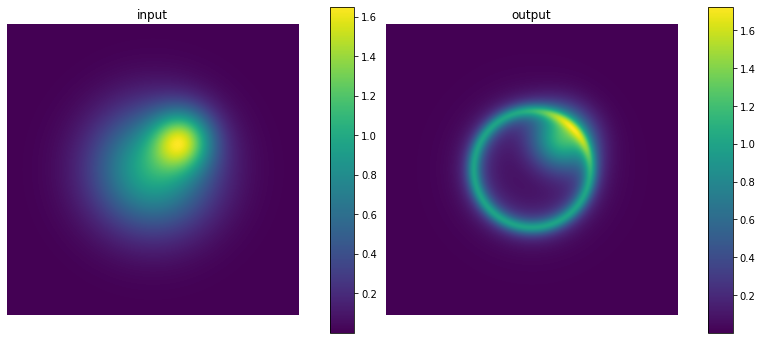

In [16]:
n = 1024  

# bin positions
coordGrid = CenteredGridCoordinates(n, n)
xs, ys = coordGrid.get_mesh()
r = np.sqrt(xs**2 + ys**2)

# create test data
a = make_gauss(r, n//5 * coordGrid.dx)
a += make_gauss_cartesian(xs, ys, n//10 * coordGrid.dx, -n//10 * coordGrid.dx,  n//10 * coordGrid.dx)

b = make_donut(r, n//5 * coordGrid.dx, n//10 * coordGrid.dx)
b += make_gauss_cartesian(xs, ys, n//10 * coordGrid.dx, -n//10 * coordGrid.dx,  n//10 * coordGrid.dx)

plot_side_by_side(a, b, title1='input', title2='output')

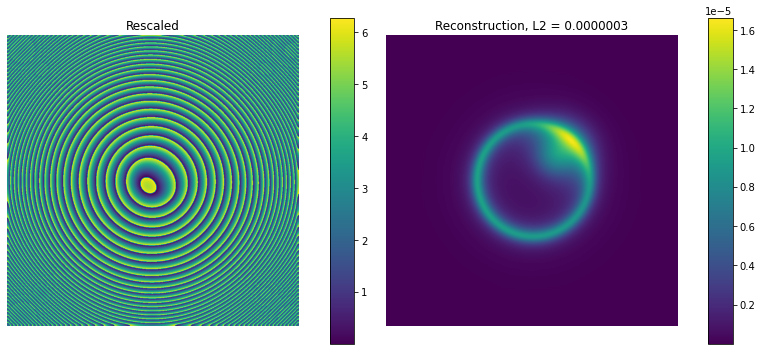

In [17]:
rescaled_phase = 1024/128 * np.array(Image.fromarray(ot_phase).resize((1024, 1024)))

pred_intensity = fourier_propagation(a, rescaled_phase * 2 * np.pi)
l2_error = L2_loss(pred_intensity, b/b.sum())
plot_side_by_side(rescaled_phase % (2 * np.pi), pred_intensity, title1=f"Rescaled", title2=f"Reconstruction, L2 = {l2_error:.7f}")

100%|██████████| 100/100 [00:11<00:00,  8.47it/s]


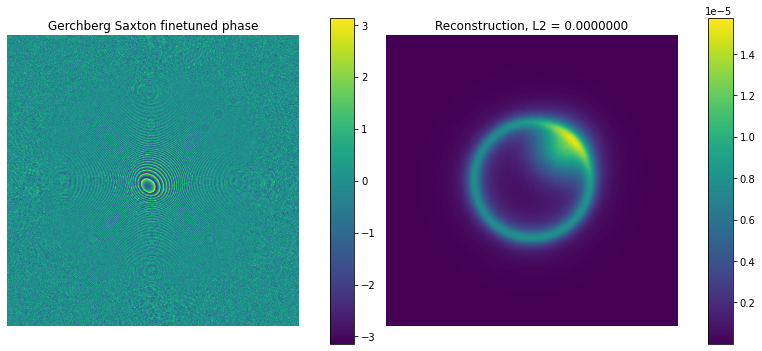

In [18]:
num_iter = 100
gs_model = GerchbergSaxton2d(num_iter)
rescaled_phase_gs_phase = gs_model(a, b, phase=rescaled_phase * 2 * np.pi)

pred_intensity = fourier_propagation(a, rescaled_phase_gs_phase)
l2_error = L2_loss(pred_intensity, b/b.sum())
plot_side_by_side(rescaled_phase_gs_phase, pred_intensity, title1=f"Gerchberg Saxton finetuned phase", title2=f"Reconstruction, L2 = {l2_error:.7f}")